# Clean and Preprocessing Data

In [1]:
# import necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import mlflow
import joblib
import math

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector

from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, RocCurveDisplay, roc_auc_score

In [2]:
# read train set as a pandas dataframe
train_set = pd.read_csv('train_set.csv')

In [3]:
# select only the features that we are going to use
X = train_set.drop(['exited'], axis=1)
y = train_set['exited']

In [4]:
# 1. make pipelines to do the necessary transformations

# 1.1 divide the qualitative and quantitative features
quantitative_columns = selector(dtype_exclude=['object'])

quantitative_columns = quantitative_columns(X)

# 1.2 apply the respective transformations with columntransformer method
preprocessor = ColumnTransformer([
    ('num', StandardScaler(), quantitative_columns)],
     remainder='drop')

# Setting up MLFlow Experiments

In [5]:
# # Setting up the mlflow experiment
# experiment_path = 'mlflow_experiments' # Defining the path of experiments in MLFlow
# experiment_name = '04_risk_assessment' # Defining the experiment name in MLFlow

# if(not(mlflow.get_experiment_by_name(experiment_name))): # If the experiment does not exist, create it
#     mlflow.create_experiment(experiment_name)
    
# mlflow.set_experiment(experiment_name) # Set the current experiment to register in MLFlow

In [6]:
# # Setting current date to save
# year = str(datetime.today().year)
# month = str(datetime.today().month)
# if len(month) == 1:
#     month = "0" + month
# day = str(datetime.today().day)
# if len(day) == 1:
#     day = "0" + day
# date = year + "/" + month + "/" + day 

# Training and Model Selection

In [7]:
def run_classifier_models(X, y, cv, scoring):
    '''Função que treina os seguintes modelos de machine learning:
    RandomForestClassifier, DecisionTreeClassifier, SGDClassifier, SVC,
    LGBMClassifier, GaussianNB.
    A função aplica a validação cruzada no conjunto de dados e retorna a média
    da métrica selecionada no conjunto de treino e validação.
    As únicas métricas ativas são Acurácia e F1 score.
    Os experimentos com os modelos são acompanhados pelo MLflow.
    
    :param X: (dataframe or numpy array) 
    Dataframe ou array com o conjunto de variáveis independentes.
    
    :param y: (series or numpy array)
    Coluna ou array com a variável dependente.
    
    :param cv: (int)
    Determina a estratégia de divisão de validação cruzada.
    
    :param scoring: (str)
    Estratégia para avaliar o desempenho do modelo de validação cruzada no conjunto de validação.
    Deve ser passada entre aspas ao chamar a função.
    '''
    # 1. Instantiate the models
    lr = LogisticRegression()
    rf = RandomForestClassifier()
    dt = DecisionTreeClassifier()
    sgdc = SGDClassifier()
    svc = SVC()
    gnb = GaussianNB()
    ada = AdaBoostClassifier()

    # 2. train and evaluate the models
    for model in (lr, rf, dt, sgdc, svc, gnb, ada):
        pipe = Pipeline(
            steps=[('preprocessor', preprocessor),
                   ('classifier', model)
                  ]
                )
        scores = cross_validate(pipe, X, y, return_train_score=True,
                                scoring=scoring, cv=cv)

        # train and validation with accuracy
        if scoring == 'accuracy':
            log_train_acc = np.mean(scores['train_score'])
            log_test_acc = np.mean(scores['test_score'])

            # track the experiment with accuraccy
            mlflow.start_run(run_name = date) 
            mlflow.log_param('Date', date) 
            mlflow.log_param('Features', X.columns)
            mlflow.log_param('Pre-processing', preprocessor) 
            mlflow.log_param('ML model', pipe[1])

            mlflow.log_metric('Train_acc', log_train_acc)
            mlflow.log_metric('Test_acc', log_test_acc)

            mlflow.end_run()

        # train and validation with f1
        if scoring == 'f1':
            log_train_f1 = np.mean(scores['train_score'])
            log_test_f1 = np.mean(scores['test_score'])

            # track the experiment with f1 score
            mlflow.start_run(run_name = date) 
            mlflow.log_param('Date', date) 
            mlflow.log_param('Features', X.columns)
            mlflow.log_param('Pre-processing', preprocessor) 
            mlflow.log_param('ML model', pipe[1])

            mlflow.log_metric('Train_f1', log_train_f1)
            mlflow.log_metric('Test_f1', log_test_f1)

            mlflow.end_run()

In [8]:
# # Run classifiers
# run_classifier_models(X, y, 5, 'accuracy')

In [9]:
# !mlflow ui

In [10]:
# mlflow.end_run()

## Improve the Model

In [11]:
# Hyperparameter tunning
# 1. Instantiate the pipeline
final_model = Pipeline(
    steps=[
        ('preprocessor', preprocessor), 
        ('dt', DecisionTreeClassifier(random_state=42))
    ]
)

# 2. Hyperparameter interval to be tested
param_grid = {
    'dt__max_depth': [None, 3, 5, 10, 15, 20, 50, 100],
}

# 3. Training and apply grid search with cross validation
grid_search = GridSearchCV(final_model, param_grid, cv = 5, scoring = 'accuracy',
                           return_train_score = True)
grid_search.fit(X, y)

# Seeing the best hyperparameters for the model
print('The best hyperparameters were:', grid_search.best_params_)

The best hyperparameters were: {'dt__max_depth': 3}


In [12]:
cvres = grid_search.cv_results_
cvres = [(mean_test_score,
            mean_train_score) for mean_test_score,
            mean_train_score in sorted(zip(cvres['mean_test_score'],
                                        cvres['mean_train_score']),
                                    reverse=True) if (math.isnan(mean_test_score) != True)]
print(
    'The mean test score and mean train score is, respectively:',
    cvres[0])

The mean test score and mean train score is, respectively: (0.72, 0.9233333333333332)


In [21]:
importances = final_model.steps[1][1].feature_importances_

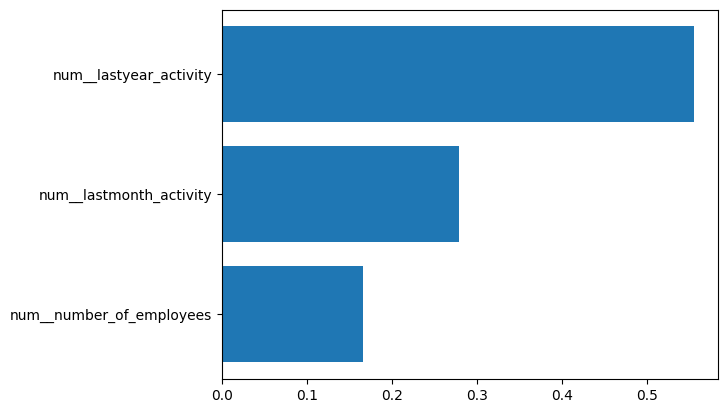

In [23]:
indices = np.argsort(importances)

fig, ax = plt.subplots()
ax.barh(range(len(importances)), importances[indices])
ax.set_yticks(range(len(importances)))
_ = ax.set_yticklabels(np.array(final_model[:-1].get_feature_names_out())[indices])

# Evaluate Model in Test Set

In [13]:
# import test set
test_set = pd.read_csv('train_set.csv')
test_set.head()

,corporation,lastmonth_activity,lastyear_activity,number_of_employees,exited
0,nciw,45,0,99,1
1,lsid,36,234,541,0
2,pwls,23,555,23,0
3,bqlx,15,11,190,1
4,zmei,100,2929,999,1


In [14]:

# select only the features that we are going to use
X_test = test_set.drop(['exited'], axis=1)
y_test = test_set['exited']

In [15]:
# Evaluate final model
final_model = grid_search.best_estimator_
final_predictions = final_model.predict(X_test)

              precision    recall  f1-score   support

           0       0.93      1.00      0.96        13
           1       1.00      0.92      0.96        13

    accuracy                           0.96        26
   macro avg       0.96      0.96      0.96        26
weighted avg       0.96      0.96      0.96        26



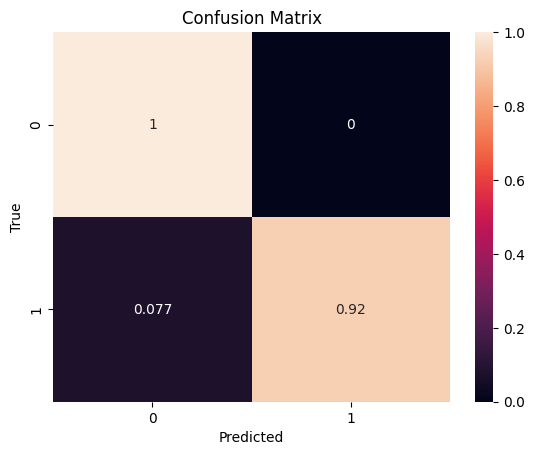

AUC: 0.9615



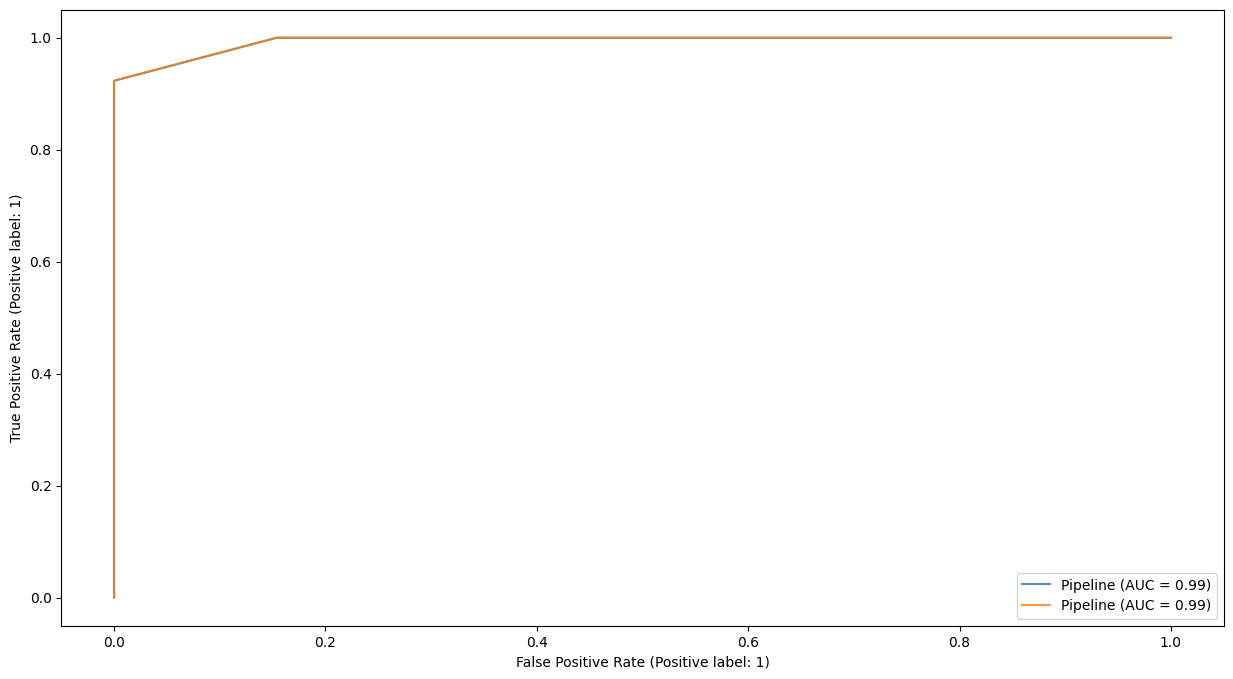

In [16]:

# print classification report
print(classification_report(y_test, final_predictions))

# plot confusion matrix
fig , ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, final_predictions, normalize='true'), annot=True, ax=ax)
ax.set_title("Confusion Matrix")
ax.set_ylabel("True")
ax.set_xlabel("Predicted")
plt.show()

# print and plot roc_auc
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, final_predictions)))

plt.figure(figsize=(15, 8))
ax = plt.gca()
lgbm_disp = RocCurveDisplay.from_estimator(final_model, X_test, y_test, ax=ax, alpha=0.8)
lgbm_disp.plot(ax=ax, alpha=0.8)
plt.show()